In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show(img, title):
    npimg = img.numpy()
    plt.figure()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

# MNIST Data

In [3]:
LEARNING_RATE = 2e-4
BETAS = (0.5, 0.999)
BATCH_SIZE = 32

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/MNIST/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/MNIST/', train=False, 
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# FaderNetwork Model

In [5]:
from models import SmallFaderAE
from models import SimpleClassifier

In [6]:
device = torch.device("cuda")

In [7]:
ae_model = SmallFaderAE(num_attributes=10).to(device)
disc_model = SimpleClassifier(input_dim=20, num_classes=10).to(device)
ae_optim = optim.Adam(ae_model.parameters(), lr=LEARNING_RATE, betas=BETAS)
disc_optim = optim.Adam(disc_model.parameters(), lr=LEARNING_RATE, betas=BETAS)

In [8]:
disc_model

SimpleClassifier(
  (linears): Sequential(
    (0): Linear(in_features=20, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=13, bias=True)
    (3): ReLU()
    (4): Linear(in_features=13, out_features=10, bias=True)
    (5): Softmax()
  )
)

In [9]:
def to_one_hot(classes, num_classes):
    batch_size = classes.shape[0]
    ret = torch.zeros((batch_size, num_classes))
    for i in range(batch_size):
        ret[i][classes[i]] = 1
    return ret

In [10]:
from torch.autograd import Variable

def train(epoch):
    ae_model.train()
    disc_model.train()

    sum_disc_loss = 0
    sum_disc_acc = 0
    sum_rec_loss = 0
    sum_adv_loss = 0
    sum_fader_loss = 0
    
    final_disc_penal_weight = 30.0
    
    # TODO: Look at this code and how they use the requires_grad parameter:
    # https://github.com/kevin1kevin1k/fader-networks-pytorch/blob/master/train_celeba.py
#     data = Variable(torch.zeros(batch_size, 1, 28, 28).float(),requires_grad=False)
#     digits = Variable(torch.zeros(batch_size, num_tags),requires_grad=False)
#     flipped_digits = Variable(torch.zeros(batch_size, num_tags),requires_grad=False)

    for data, digits in tqdm(train_loader):
        
#         input_img.data.copy_(batch_img)
#         given_attr.data.copy_(batch_attr)
#         flipped_attr.data.copy_(1-batch_attr)
        
        data = data.to(device)
        
        digits = digits.to(device)
        hot_digits = to_one_hot(digits, 10).to(device)

        # Encode data
        z = ae_model.encode(data)
        
        # Train discriminator for 3 steps
        for _ in range(3):
            disc_optim.zero_grad()
            z_in = z.detach()
            digit_preds = disc_model(z_in)
            disc_loss = F.cross_entropy(digit_preds, digits, reduction='sum')
            sum_disc_loss += disc_loss.item()
        
            disc_loss.backward()
            disc_optim.step()
        
        # Compute discriminator accuracy
        _, digit_preds_argmax = torch.max(digit_preds, 1)
        disc_acc = torch.sum(digit_preds_argmax == digits).float()
        sum_disc_acc += disc_acc
        
        # Compute discriminator peanlization weight based on schedule
        c = 5
        if epoch < c:
            curr_disc_penal_weight = 0
        else:
            curr_disc_penal_weight = min(1, (epoch - c) / 100) * final_disc_penal_weight
        
        # Compute auto encoder loss
        ae_model.zero_grad()
        digit_preds_to_fool = disc_model(z)
        reconst_batch = ae_model.decode(z, hot_digits)
                
        rec_loss = F.binary_cross_entropy(reconst_batch, data, reduction='sum')
        sum_rec_loss += rec_loss.item()
        
        adv_loss = F.cross_entropy(digit_preds_to_fool, digits, reduction='sum')
        sum_adv_loss += adv_loss.item()
        
        fader_loss = rec_loss - curr_disc_penal_weight*adv_loss
        sum_fader_loss += fader_loss.item()        
        
        # Train auto encoder
        fader_loss.backward()
        ae_optim.step()
        
        
    train_size = len(train_loader.dataset)
    print('====> Epoch: {} Fader Loss: {:.4f} | Adv Loss: {:.4f} | Rec Loss: {:.4f} \n\t| Adj Disc Loss: {:.4f} | Disc Acc: {:.4f}'.format(
          epoch, sum_fader_loss/train_size, sum_adv_loss/train_size, 
        sum_rec_loss/train_size, curr_disc_penal_weight*sum_disc_loss/train_size, sum_disc_acc/train_size))

def test(epoch):
    ae_model.eval()
    disc_model.eval()
    with torch.no_grad():
        for data_batch, digits in tqdm(test_loader):
            data_batch = data_batch[:10].to(device)
            digits = digits[:10].to(device)
            
            hot_digits = to_one_hot(digits, 10).to(device)

            batch_z = ae_model.encode(data_batch)
            
            assert batch_z.shape[0] == 10

            faders = torch.eye(10).to(device)

            show(make_grid(data_batch.detach().cpu(), nrow=10), 'True {}'.format(epoch))

            reconst = ae_model.decode(batch_z, hot_digits).cpu()
            show(make_grid(reconst.view(10, 1, 28, 28), nrow=10), 'True Reconst {}'.format(epoch))

            fader_reconst = ae_model.decode(batch_z, faders).cpu()
            show(make_grid(fader_reconst.view(10, 1, 28, 28), nrow=10), 'Fader Reconst {}'.format(epoch))
            break

In [11]:
dataset = train_loader.dataset

In [12]:
ae_path = 'weights/{}_{}.pt'.format(ae_model.__class__.__name__, dataset.__class__.__name__)
ae_path

'weights/SmallFaderAE_MNIST.pt'

In [13]:
epochs_trained_path = ae_path[:-3] + '_epochs.npy'
epochs_trained_path

'weights/SmallFaderAE_MNIST_epochs.npy'

In [14]:
disc_path = 'weights/{}_{}.pt'.format(disc_model.__class__.__name__, dataset.__class__.__name__)
disc_path

'weights/SimpleClassifier_MNIST.pt'

In [15]:
def save(epoch):
    torch.save(ae_model.state_dict(), ae_path)
    torch.save(disc_model.state_dict(), disc_path)
    np.save(epochs_trained_path, epoch)

In [16]:
import os

def load():
    epochs_trained = 0
    if os.path.exists(ae_path) and os.path.exists(disc_path) and os.path.exists(epochs_trained_path):
        ae_model.load_state_dict(torch.load(ae_path))    
        disc_model.load_state_dict(torch.load(disc_path))
        epochs_trained = np.load(epochs_trained_path) + 1
        print("Loaded with {} epochs trained".format(epochs_trained))
    else:
        print("Starting from scratch")
    return epochs_trained

# Train

### Try to load if possible

In [17]:
epochs_trained = load()

Starting from scratch


### Train!

In [18]:
epochs = 1000

  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 0 Fader Loss: 132.4288 | Adv Loss: 1.9249 | Rec Loss: 132.4288 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.5531


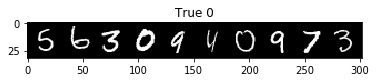

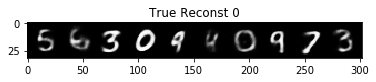

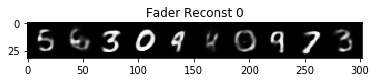


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 1 Fader Loss: 88.9696 | Adv Loss: 1.7094 | Rec Loss: 88.9696 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.7662


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 2 Fader Loss: 83.8109 | Adv Loss: 1.6625 | Rec Loss: 83.8109 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.8076


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 3 Fader Loss: 81.1727 | Adv Loss: 1.6492 | Rec Loss: 81.1727 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.8181


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 4 Fader Loss: 79.5076 | Adv Loss: 1.6415 | Rec Loss: 79.5076 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.8239


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 5 Fader Loss: 78.4225 | Adv Loss: 1.6353 | Rec Loss: 78.4225 
	| Adj Disc Loss: 0.0000 | Disc Acc: 0.8292


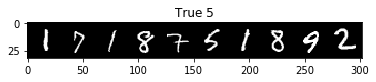

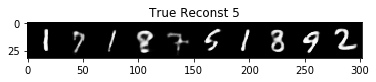

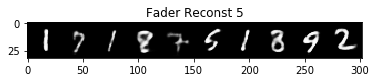


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 6 Fader Loss: 76.8538 | Adv Loss: 1.6301 | Rec Loss: 77.6688 
	| Adj Disc Loss: 2.4515 | Disc Acc: 0.8338


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 7 Fader Loss: 75.4941 | Adv Loss: 1.6225 | Rec Loss: 77.1166 
	| Adj Disc Loss: 4.8809 | Disc Acc: 0.8417


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 8 Fader Loss: 74.3444 | Adv Loss: 1.5645 | Rec Loss: 76.6911 
	| Adj Disc Loss: 7.0639 | Disc Acc: 0.9049


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 9 Fader Loss: 73.2349 | Adv Loss: 1.5553 | Rec Loss: 76.3456 
	| Adj Disc Loss: 9.3624 | Disc Acc: 0.9130


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 10 Fader Loss: 72.1915 | Adv Loss: 1.5511 | Rec Loss: 76.0692 
	| Adj Disc Loss: 11.6709 | Disc Acc: 0.9161


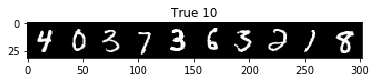

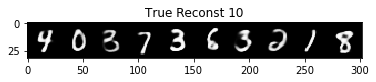

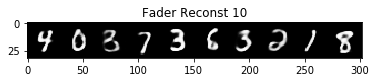


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 11 Fader Loss: 71.1870 | Adv Loss: 1.5487 | Rec Loss: 75.8332 
	| Adj Disc Loss: 13.9836 | Disc Acc: 0.9171


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 12 Fader Loss: 70.2175 | Adv Loss: 1.5472 | Rec Loss: 75.6327 
	| Adj Disc Loss: 16.2984 | Disc Acc: 0.9174


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 13 Fader Loss: 69.2663 | Adv Loss: 1.5461 | Rec Loss: 75.4508 
	| Adj Disc Loss: 18.6146 | Disc Acc: 0.9188


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 14 Fader Loss: 68.3483 | Adv Loss: 1.5452 | Rec Loss: 75.3016 
	| Adj Disc Loss: 20.9291 | Disc Acc: 0.9193


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 15 Fader Loss: 67.4460 | Adv Loss: 1.5453 | Rec Loss: 75.1724 
	| Adj Disc Loss: 23.2553 | Disc Acc: 0.9191


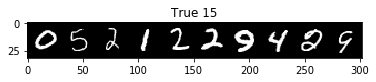

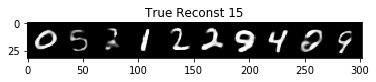

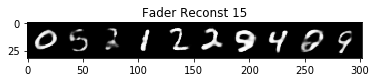


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 16 Fader Loss: 66.5509 | Adv Loss: 1.5457 | Rec Loss: 75.0521 
	| Adj Disc Loss: 25.5886 | Disc Acc: 0.9185


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 17 Fader Loss: 65.6687 | Adv Loss: 1.5466 | Rec Loss: 74.9481 
	| Adj Disc Loss: 27.9301 | Disc Acc: 0.9168


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 18 Fader Loss: 64.7938 | Adv Loss: 1.5471 | Rec Loss: 74.8498 
	| Adj Disc Loss: 30.2688 | Disc Acc: 0.9159


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 19 Fader Loss: 63.9307 | Adv Loss: 1.5482 | Rec Loss: 74.7679 
	| Adj Disc Loss: 32.6195 | Disc Acc: 0.9150


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 20 Fader Loss: 63.0717 | Adv Loss: 1.5498 | Rec Loss: 74.6954 
	| Adj Disc Loss: 34.9884 | Disc Acc: 0.9129


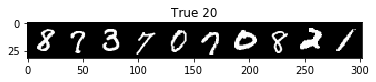

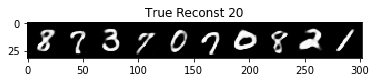

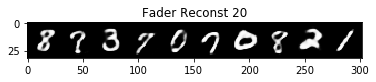


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 21 Fader Loss: 62.2144 | Adv Loss: 1.5516 | Rec Loss: 74.6271 
	| Adj Disc Loss: 37.3619 | Disc Acc: 0.9110


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 22 Fader Loss: 61.3631 | Adv Loss: 1.5530 | Rec Loss: 74.5637 
	| Adj Disc Loss: 39.7368 | Disc Acc: 0.9095


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 23 Fader Loss: 60.5176 | Adv Loss: 1.5557 | Rec Loss: 74.5185 
	| Adj Disc Loss: 42.1458 | Disc Acc: 0.9067


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 24 Fader Loss: 59.6743 | Adv Loss: 1.5583 | Rec Loss: 74.4784 
	| Adj Disc Loss: 44.5669 | Disc Acc: 0.9038


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 25 Fader Loss: 58.8314 | Adv Loss: 1.5610 | Rec Loss: 74.4415 
	| Adj Disc Loss: 46.9923 | Disc Acc: 0.9014


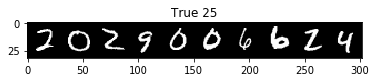

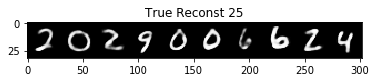

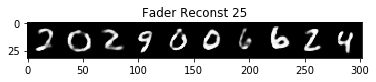


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 26 Fader Loss: 57.9916 | Adv Loss: 1.5643 | Rec Loss: 74.4170 
	| Adj Disc Loss: 49.4497 | Disc Acc: 0.8982


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 27 Fader Loss: 57.1513 | Adv Loss: 1.5678 | Rec Loss: 74.3967 
	| Adj Disc Loss: 51.9244 | Disc Acc: 0.8945


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 28 Fader Loss: 56.3066 | Adv Loss: 1.5732 | Rec Loss: 74.3980 
	| Adj Disc Loss: 54.4728 | Disc Acc: 0.8888


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 29 Fader Loss: 55.4707 | Adv Loss: 1.5780 | Rec Loss: 74.4069 
	| Adj Disc Loss: 57.0171 | Disc Acc: 0.8838


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 30 Fader Loss: 54.6174 | Adv Loss: 1.5847 | Rec Loss: 74.4258 
	| Adj Disc Loss: 59.6512 | Disc Acc: 0.8775


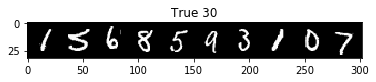

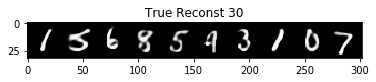

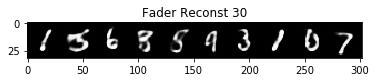


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 31 Fader Loss: 53.7560 | Adv Loss: 1.5937 | Rec Loss: 74.4735 
	| Adj Disc Loss: 62.3926 | Disc Acc: 0.8673


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 32 Fader Loss: 52.8741 | Adv Loss: 1.6073 | Rec Loss: 74.5733 
	| Adj Disc Loss: 65.3550 | Disc Acc: 0.8542


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 33 Fader Loss: 51.9597 | Adv Loss: 1.6250 | Rec Loss: 74.7093 
	| Adj Disc Loss: 68.5256 | Disc Acc: 0.8359


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 34 Fader Loss: 51.0235 | Adv Loss: 1.6479 | Rec Loss: 74.9187 
	| Adj Disc Loss: 71.9807 | Disc Acc: 0.8118


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 35 Fader Loss: 50.0426 | Adv Loss: 1.6742 | Rec Loss: 75.1560 
	| Adj Disc Loss: 75.6561 | Disc Acc: 0.7849


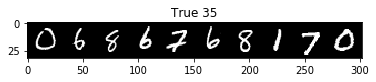

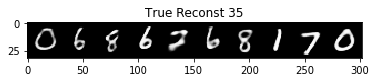

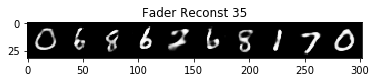


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 36 Fader Loss: 49.0697 | Adv Loss: 1.6970 | Rec Loss: 75.3729 
	| Adj Disc Loss: 79.2566 | Disc Acc: 0.7620


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 37 Fader Loss: 48.0086 | Adv Loss: 1.7391 | Rec Loss: 75.8348 
	| Adj Disc Loss: 83.8674 | Disc Acc: 0.7192


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 38 Fader Loss: 46.6223 | Adv Loss: 1.8314 | Rec Loss: 76.8396 
	| Adj Disc Loss: 91.0813 | Disc Acc: 0.6246


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 39 Fader Loss: 45.2954 | Adv Loss: 1.8787 | Rec Loss: 77.2335 
	| Adj Disc Loss: 96.2566 | Disc Acc: 0.5751


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 40 Fader Loss: 44.2030 | Adv Loss: 1.8909 | Rec Loss: 77.2933 
	| Adj Disc Loss: 99.7050 | Disc Acc: 0.5628


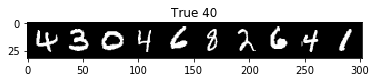

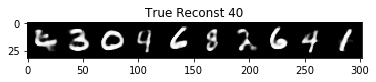

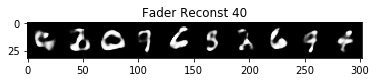


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 41 Fader Loss: 43.1093 | Adv Loss: 1.9105 | Rec Loss: 77.4974 
	| Adj Disc Loss: 103.6166 | Disc Acc: 0.5439


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 42 Fader Loss: 42.1079 | Adv Loss: 1.9582 | Rec Loss: 78.3338 
	| Adj Disc Loss: 109.1541 | Disc Acc: 0.4947


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 43 Fader Loss: 41.1441 | Adv Loss: 1.9704 | Rec Loss: 78.5815 
	| Adj Disc Loss: 112.7830 | Disc Acc: 0.4829


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 44 Fader Loss: 39.8281 | Adv Loss: 2.0131 | Rec Loss: 79.0846 
	| Adj Disc Loss: 118.2477 | Disc Acc: 0.4395


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 45 Fader Loss: 38.5878 | Adv Loss: 2.0599 | Rec Loss: 79.7863 
	| Adj Disc Loss: 124.0914 | Disc Acc: 0.3898


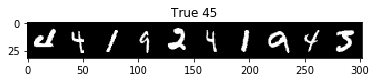

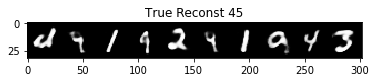

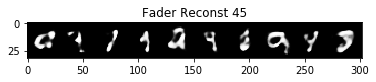


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 46 Fader Loss: 37.0994 | Adv Loss: 2.0996 | Rec Loss: 80.1411 
	| Adj Disc Loss: 129.6342 | Disc Acc: 0.3480


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 47 Fader Loss: 36.2536 | Adv Loss: 2.1074 | Rec Loss: 80.5096 
	| Adj Disc Loss: 133.2935 | Disc Acc: 0.3389


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 48 Fader Loss: 35.4553 | Adv Loss: 2.1138 | Rec Loss: 80.9011 
	| Adj Disc Loss: 136.8935 | Disc Acc: 0.3331


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 49 Fader Loss: 34.8715 | Adv Loss: 2.0807 | Rec Loss: 80.6459 
	| Adj Disc Loss: 137.9074 | Disc Acc: 0.3681


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 50 Fader Loss: 33.5155 | Adv Loss: 2.1101 | Rec Loss: 80.9926 
	| Adj Disc Loss: 143.0373 | Disc Acc: 0.3374


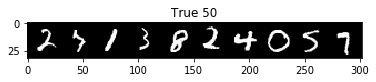

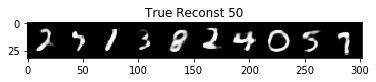

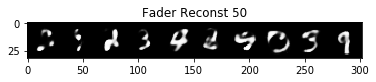


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 51 Fader Loss: 32.5378 | Adv Loss: 2.1220 | Rec Loss: 81.3428 
	| Adj Disc Loss: 147.0009 | Disc Acc: 0.3244


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 52 Fader Loss: 31.0024 | Adv Loss: 2.1511 | Rec Loss: 81.5526 
	| Adj Disc Loss: 152.2568 | Disc Acc: 0.2941


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 53 Fader Loss: 30.0309 | Adv Loss: 2.1491 | Rec Loss: 81.6097 
	| Adj Disc Loss: 155.3899 | Disc Acc: 0.2949


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 54 Fader Loss: 28.6369 | Adv Loss: 2.1502 | Rec Loss: 81.3166 
	| Adj Disc Loss: 158.6928 | Disc Acc: 0.2948


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 55 Fader Loss: 27.6949 | Adv Loss: 2.1519 | Rec Loss: 81.4918 
	| Adj Disc Loss: 162.0618 | Disc Acc: 0.2914


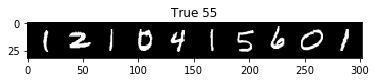

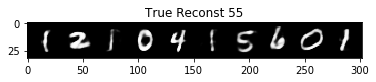

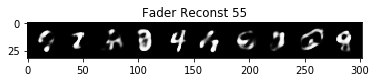


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 56 Fader Loss: 26.3080 | Adv Loss: 2.1690 | Rec Loss: 81.6171 
	| Adj Disc Loss: 166.5962 | Disc Acc: 0.2740


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 57 Fader Loss: 24.6501 | Adv Loss: 2.1815 | Rec Loss: 81.3695 
	| Adj Disc Loss: 170.8215 | Disc Acc: 0.2603


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 58 Fader Loss: 23.5438 | Adv Loss: 2.1785 | Rec Loss: 81.2729 
	| Adj Disc Loss: 173.9093 | Disc Acc: 0.2672


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 59 Fader Loss: 22.2568 | Adv Loss: 2.1866 | Rec Loss: 81.2948 
	| Adj Disc Loss: 177.8270 | Disc Acc: 0.2575


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 60 Fader Loss: 21.1361 | Adv Loss: 2.2033 | Rec Loss: 81.7267 
	| Adj Disc Loss: 182.4940 | Disc Acc: 0.2379


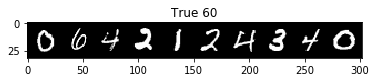

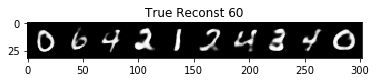

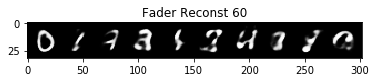


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 61 Fader Loss: 20.0826 | Adv Loss: 2.2036 | Rec Loss: 81.7835 
	| Adj Disc Loss: 185.8389 | Disc Acc: 0.2388


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 62 Fader Loss: 18.6892 | Adv Loss: 2.2065 | Rec Loss: 81.5747 
	| Adj Disc Loss: 189.4282 | Disc Acc: 0.2360


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 63 Fader Loss: 17.9299 | Adv Loss: 2.1922 | Rec Loss: 81.5025 
	| Adj Disc Loss: 191.4929 | Disc Acc: 0.2531


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 64 Fader Loss: 15.9145 | Adv Loss: 2.2221 | Rec Loss: 81.4651 
	| Adj Disc Loss: 197.4169 | Disc Acc: 0.2220


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 65 Fader Loss: 14.8505 | Adv Loss: 2.2271 | Rec Loss: 81.6628 
	| Adj Disc Loss: 201.2379 | Disc Acc: 0.2139


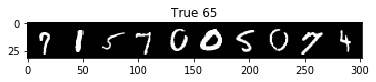

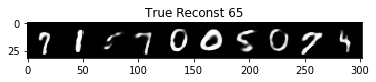

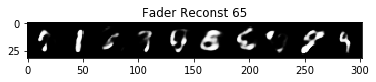


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 66 Fader Loss: 14.1926 | Adv Loss: 2.2203 | Rec Loss: 81.9111 
	| Adj Disc Loss: 203.9570 | Disc Acc: 0.2236


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 67 Fader Loss: 13.4111 | Adv Loss: 2.2191 | Rec Loss: 82.2017 
	| Adj Disc Loss: 207.1907 | Disc Acc: 0.2232


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 68 Fader Loss: 12.3763 | Adv Loss: 2.2101 | Rec Loss: 81.9939 
	| Adj Disc Loss: 209.6564 | Disc Acc: 0.2326


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 69 Fader Loss: 11.0259 | Adv Loss: 2.2084 | Rec Loss: 81.6944 
	| Adj Disc Loss: 212.8352 | Disc Acc: 0.2369


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 70 Fader Loss: 9.8556 | Adv Loss: 2.2216 | Rec Loss: 82.0586 
	| Adj Disc Loss: 217.4166 | Disc Acc: 0.2194


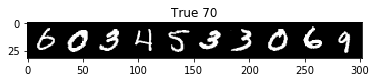

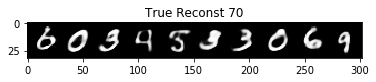

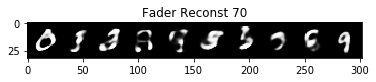


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 71 Fader Loss: 8.8891 | Adv Loss: 2.2324 | Rec Loss: 82.5574 
	| Adj Disc Loss: 221.7797 | Disc Acc: 0.2059


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 72 Fader Loss: 7.7416 | Adv Loss: 2.2244 | Rec Loss: 82.2587 
	| Adj Disc Loss: 224.3376 | Disc Acc: 0.2179


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 73 Fader Loss: 6.2084 | Adv Loss: 2.2323 | Rec Loss: 82.1051 
	| Adj Disc Loss: 228.5289 | Disc Acc: 0.2083


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 74 Fader Loss: 4.1045 | Adv Loss: 2.2526 | Rec Loss: 81.8187 
	| Adj Disc Loss: 234.0173 | Disc Acc: 0.1853


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 75 Fader Loss: 3.0110 | Adv Loss: 2.2535 | Rec Loss: 81.8821 
	| Adj Disc Loss: 237.5193 | Disc Acc: 0.1835


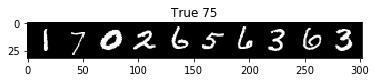

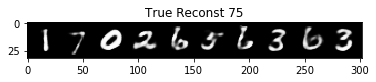

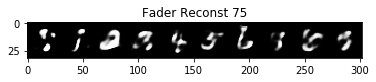


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 76 Fader Loss: 2.4851 | Adv Loss: 2.2444 | Rec Loss: 82.1624 
	| Adj Disc Loss: 240.0002 | Disc Acc: 0.1917


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 77 Fader Loss: 1.8467 | Adv Loss: 2.2421 | Rec Loss: 82.5627 
	| Adj Disc Loss: 243.1791 | Disc Acc: 0.1980


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 78 Fader Loss: 0.6664 | Adv Loss: 2.2397 | Rec Loss: 82.4152 
	| Adj Disc Loss: 246.1490 | Disc Acc: 0.2003


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 79 Fader Loss: -0.2783 | Adv Loss: 2.2348 | Rec Loss: 82.4090 
	| Adj Disc Loss: 248.9710 | Disc Acc: 0.2052


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 80 Fader Loss: -1.8159 | Adv Loss: 2.2365 | Rec Loss: 82.0515 
	| Adj Disc Loss: 252.5557 | Disc Acc: 0.2007


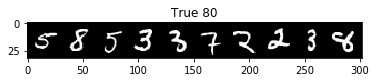

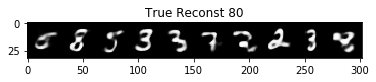

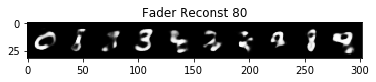


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 81 Fader Loss: -2.7276 | Adv Loss: 2.2409 | Rec Loss: 82.4259 
	| Adj Disc Loss: 256.5117 | Disc Acc: 0.1944


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 82 Fader Loss: -3.9277 | Adv Loss: 2.2378 | Rec Loss: 82.2267 
	| Adj Disc Loss: 259.5015 | Disc Acc: 0.2018


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 83 Fader Loss: -5.0807 | Adv Loss: 2.2406 | Rec Loss: 82.3036 
	| Adj Disc Loss: 263.1778 | Disc Acc: 0.1969


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 84 Fader Loss: -6.0708 | Adv Loss: 2.2386 | Rec Loss: 82.3523 
	| Adj Disc Loss: 266.3293 | Disc Acc: 0.1993


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 85 Fader Loss: -7.2252 | Adv Loss: 2.2453 | Rec Loss: 82.5879 
	| Adj Disc Loss: 270.4183 | Disc Acc: 0.1906


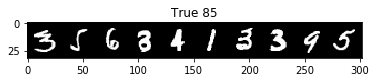

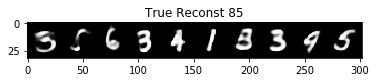

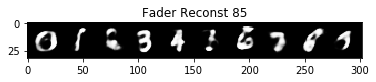


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 86 Fader Loss: -8.0227 | Adv Loss: 2.2388 | Rec Loss: 82.6490 
	| Adj Disc Loss: 273.0349 | Disc Acc: 0.1994


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 87 Fader Loss: -8.9383 | Adv Loss: 2.2352 | Rec Loss: 82.7057 
	| Adj Disc Loss: 275.9516 | Disc Acc: 0.2024


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 88 Fader Loss: -10.3794 | Adv Loss: 2.2500 | Rec Loss: 82.9971 
	| Adj Disc Loss: 281.1628 | Disc Acc: 0.1855


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 89 Fader Loss: -11.4451 | Adv Loss: 2.2462 | Rec Loss: 82.8935 
	| Adj Disc Loss: 284.1347 | Disc Acc: 0.1919


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 90 Fader Loss: -12.4322 | Adv Loss: 2.2399 | Rec Loss: 82.7641 
	| Adj Disc Loss: 286.7370 | Disc Acc: 0.1959


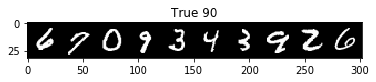

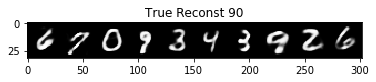

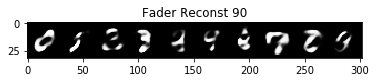


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 91 Fader Loss: -13.9233 | Adv Loss: 2.2546 | Rec Loss: 83.0265 
	| Adj Disc Loss: 291.9962 | Disc Acc: 0.1786


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 92 Fader Loss: -15.0632 | Adv Loss: 2.2525 | Rec Loss: 82.9205 
	| Adj Disc Loss: 295.0903 | Disc Acc: 0.1837


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 93 Fader Loss: -16.3938 | Adv Loss: 2.2566 | Rec Loss: 82.8958 
	| Adj Disc Loss: 298.9558 | Disc Acc: 0.1754


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 94 Fader Loss: -17.3348 | Adv Loss: 2.2529 | Rec Loss: 82.9172 
	| Adj Disc Loss: 301.9067 | Disc Acc: 0.1833


  0%|          | 0/313 [00:00<?, ?it/s]

====> Epoch: 95 Fader Loss: -18.7359 | Adv Loss: 2.2549 | Rec Loss: 82.7330 
	| Adj Disc Loss: 305.5600 | Disc Acc: 0.1787


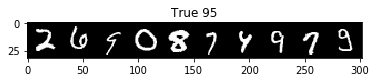

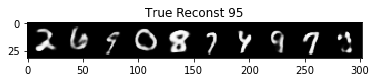

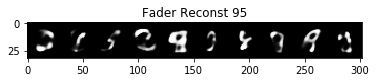


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 96 Fader Loss: -20.0826 | Adv Loss: 2.2584 | Rec Loss: 82.6743 
	| Adj Disc Loss: 309.4328 | Disc Acc: 0.1738


  0%|          | 0/1875 [00:00<?, ?it/s]

====> Epoch: 97 Fader Loss: -21.0646 | Adv Loss: 2.2545 | Rec Loss: 82.6428 
	| Adj Disc Loss: 312.2968 | Disc Acc: 0.1790


 73%|███████▎  | 1370/1875 [00:14<00:05, 93.34it/s]

In [ ]:
%%time
for epoch in range(epochs_trained, epochs + epochs_trained):
    train(epoch)
    
    if epoch % 5 == 0:
        test(epoch)
        save(epoch)

In [ ]:
save(epoch)